In [19]:
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
sc.settings.verbosity = 0
sc.settings.set_figure_params(dpi=80, facecolor="white")

### 1. load data
Using `V1_Breast_Cancer_Block_A_Section_1` dataset from 10x Genomics Visium.

In [21]:
adata = sc.datasets.visium_sge(sample_id='V1_Breast_Cancer_Block_A_Section_1')
adata.var_names_make_unique()
print(adata)


/Users/gloriasong/anaconda3/envs/single_cell_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/gloriasong/anaconda3/envs/single_cell_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


### Initial visualize

Spatial expression data of breast cancer tissue sections.

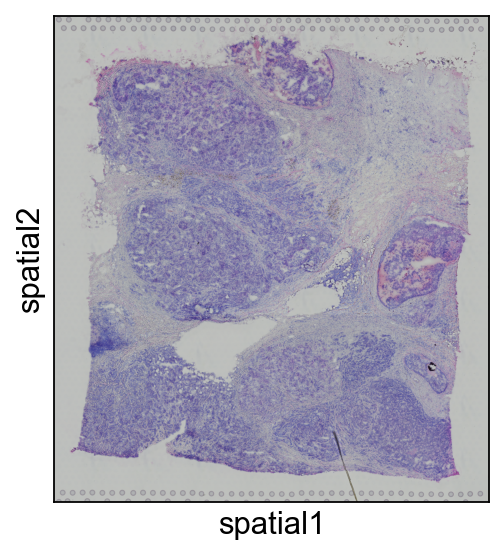

In [22]:
sc.pl.spatial(adata, img_key="hires")


The axes `spatial1` and `spatial2` are spatial coordinate axes, representing the distribution of Visium spots in the tissue.

Also can select specific genes to observe their spatial expression patterns on the tissue.

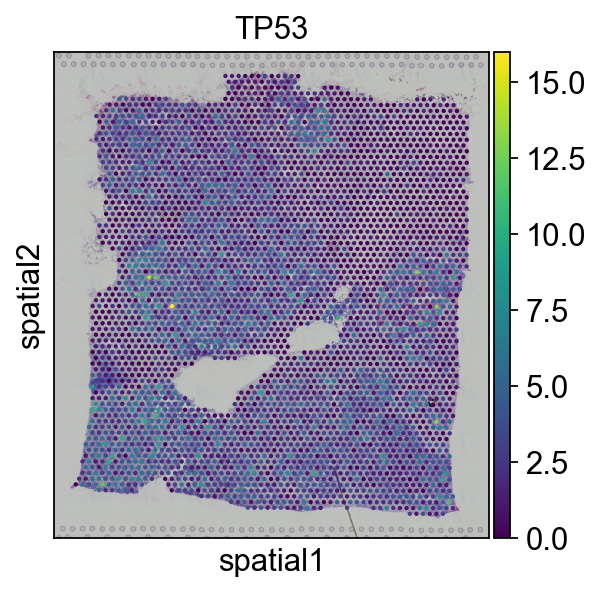

In [23]:
sc.pl.spatial(adata, color=["TP53"], img_key="hires")

Those Black Hexagonal Grid represent spatial gene expression spots.

Each spot captures RNA from multiple cells and measures the expression level(count) of the TP53 gene.

High TP53 expression (yellow regions) may indicate active tumor areas or mutation-related upregulation.

### QC

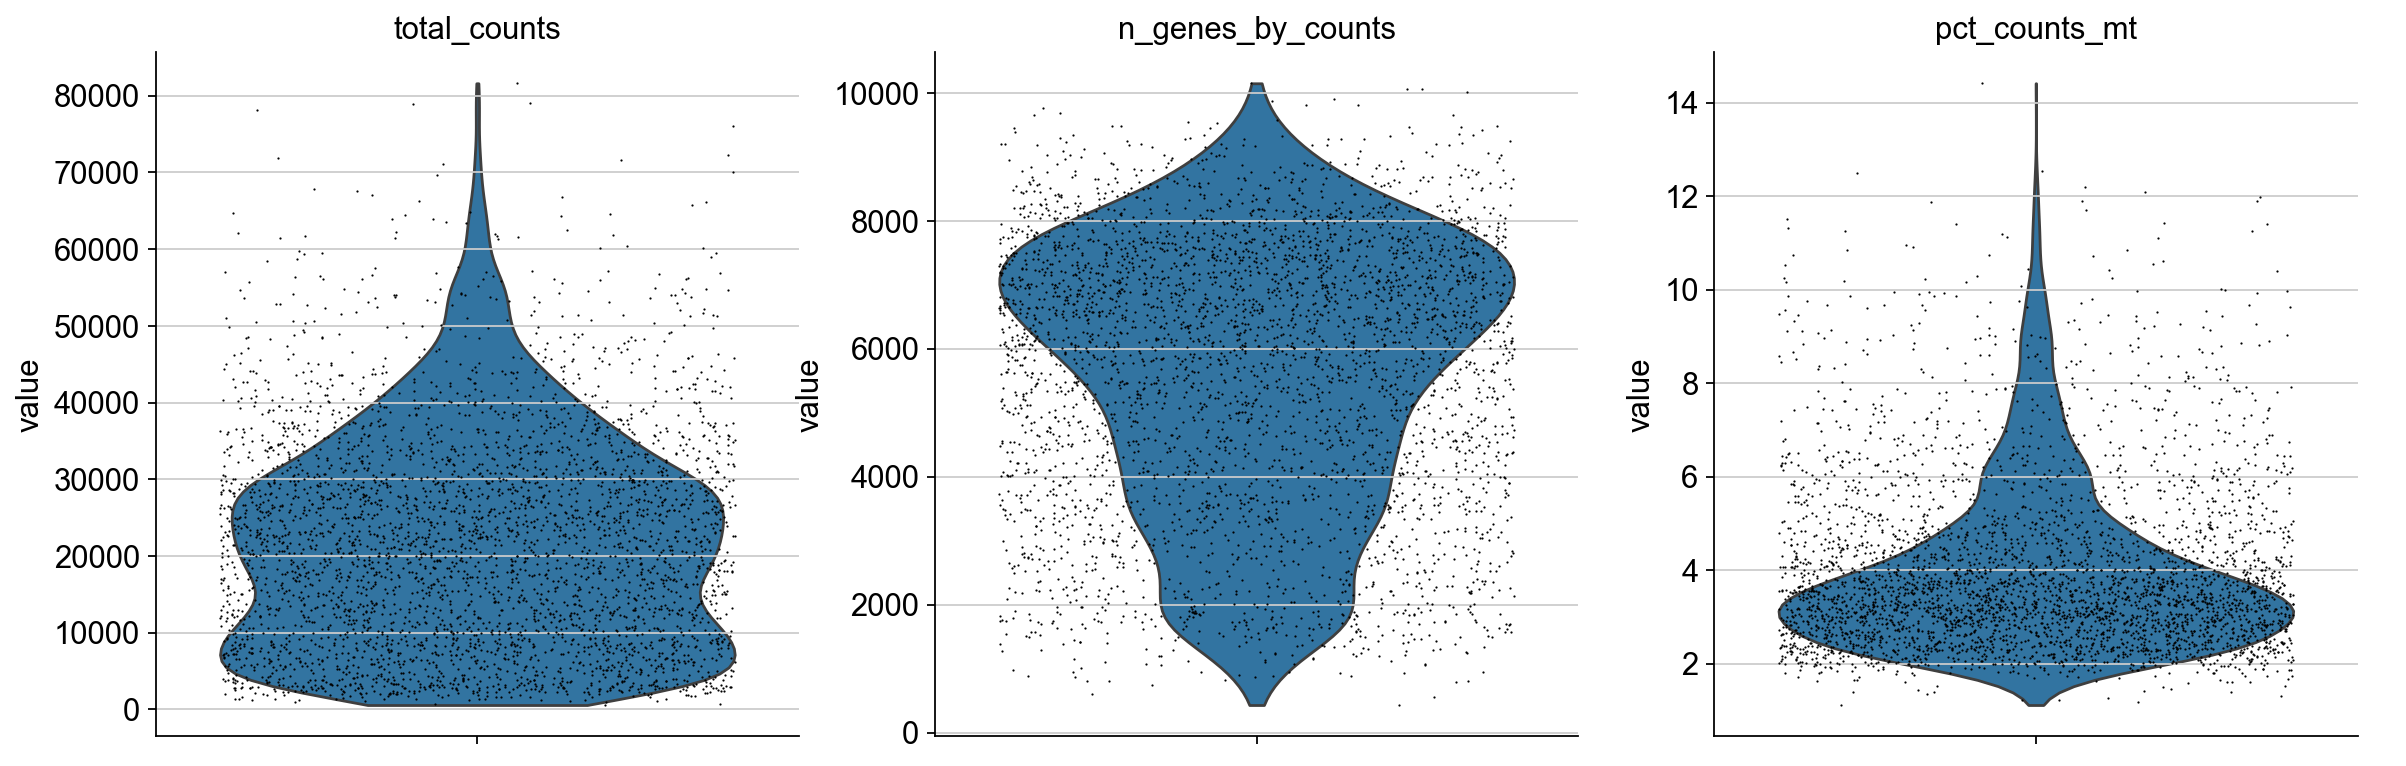

In [24]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], inplace=True, log1p=True
)

sc.pl.violin(
    adata,
    ["total_counts", "n_genes_by_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)


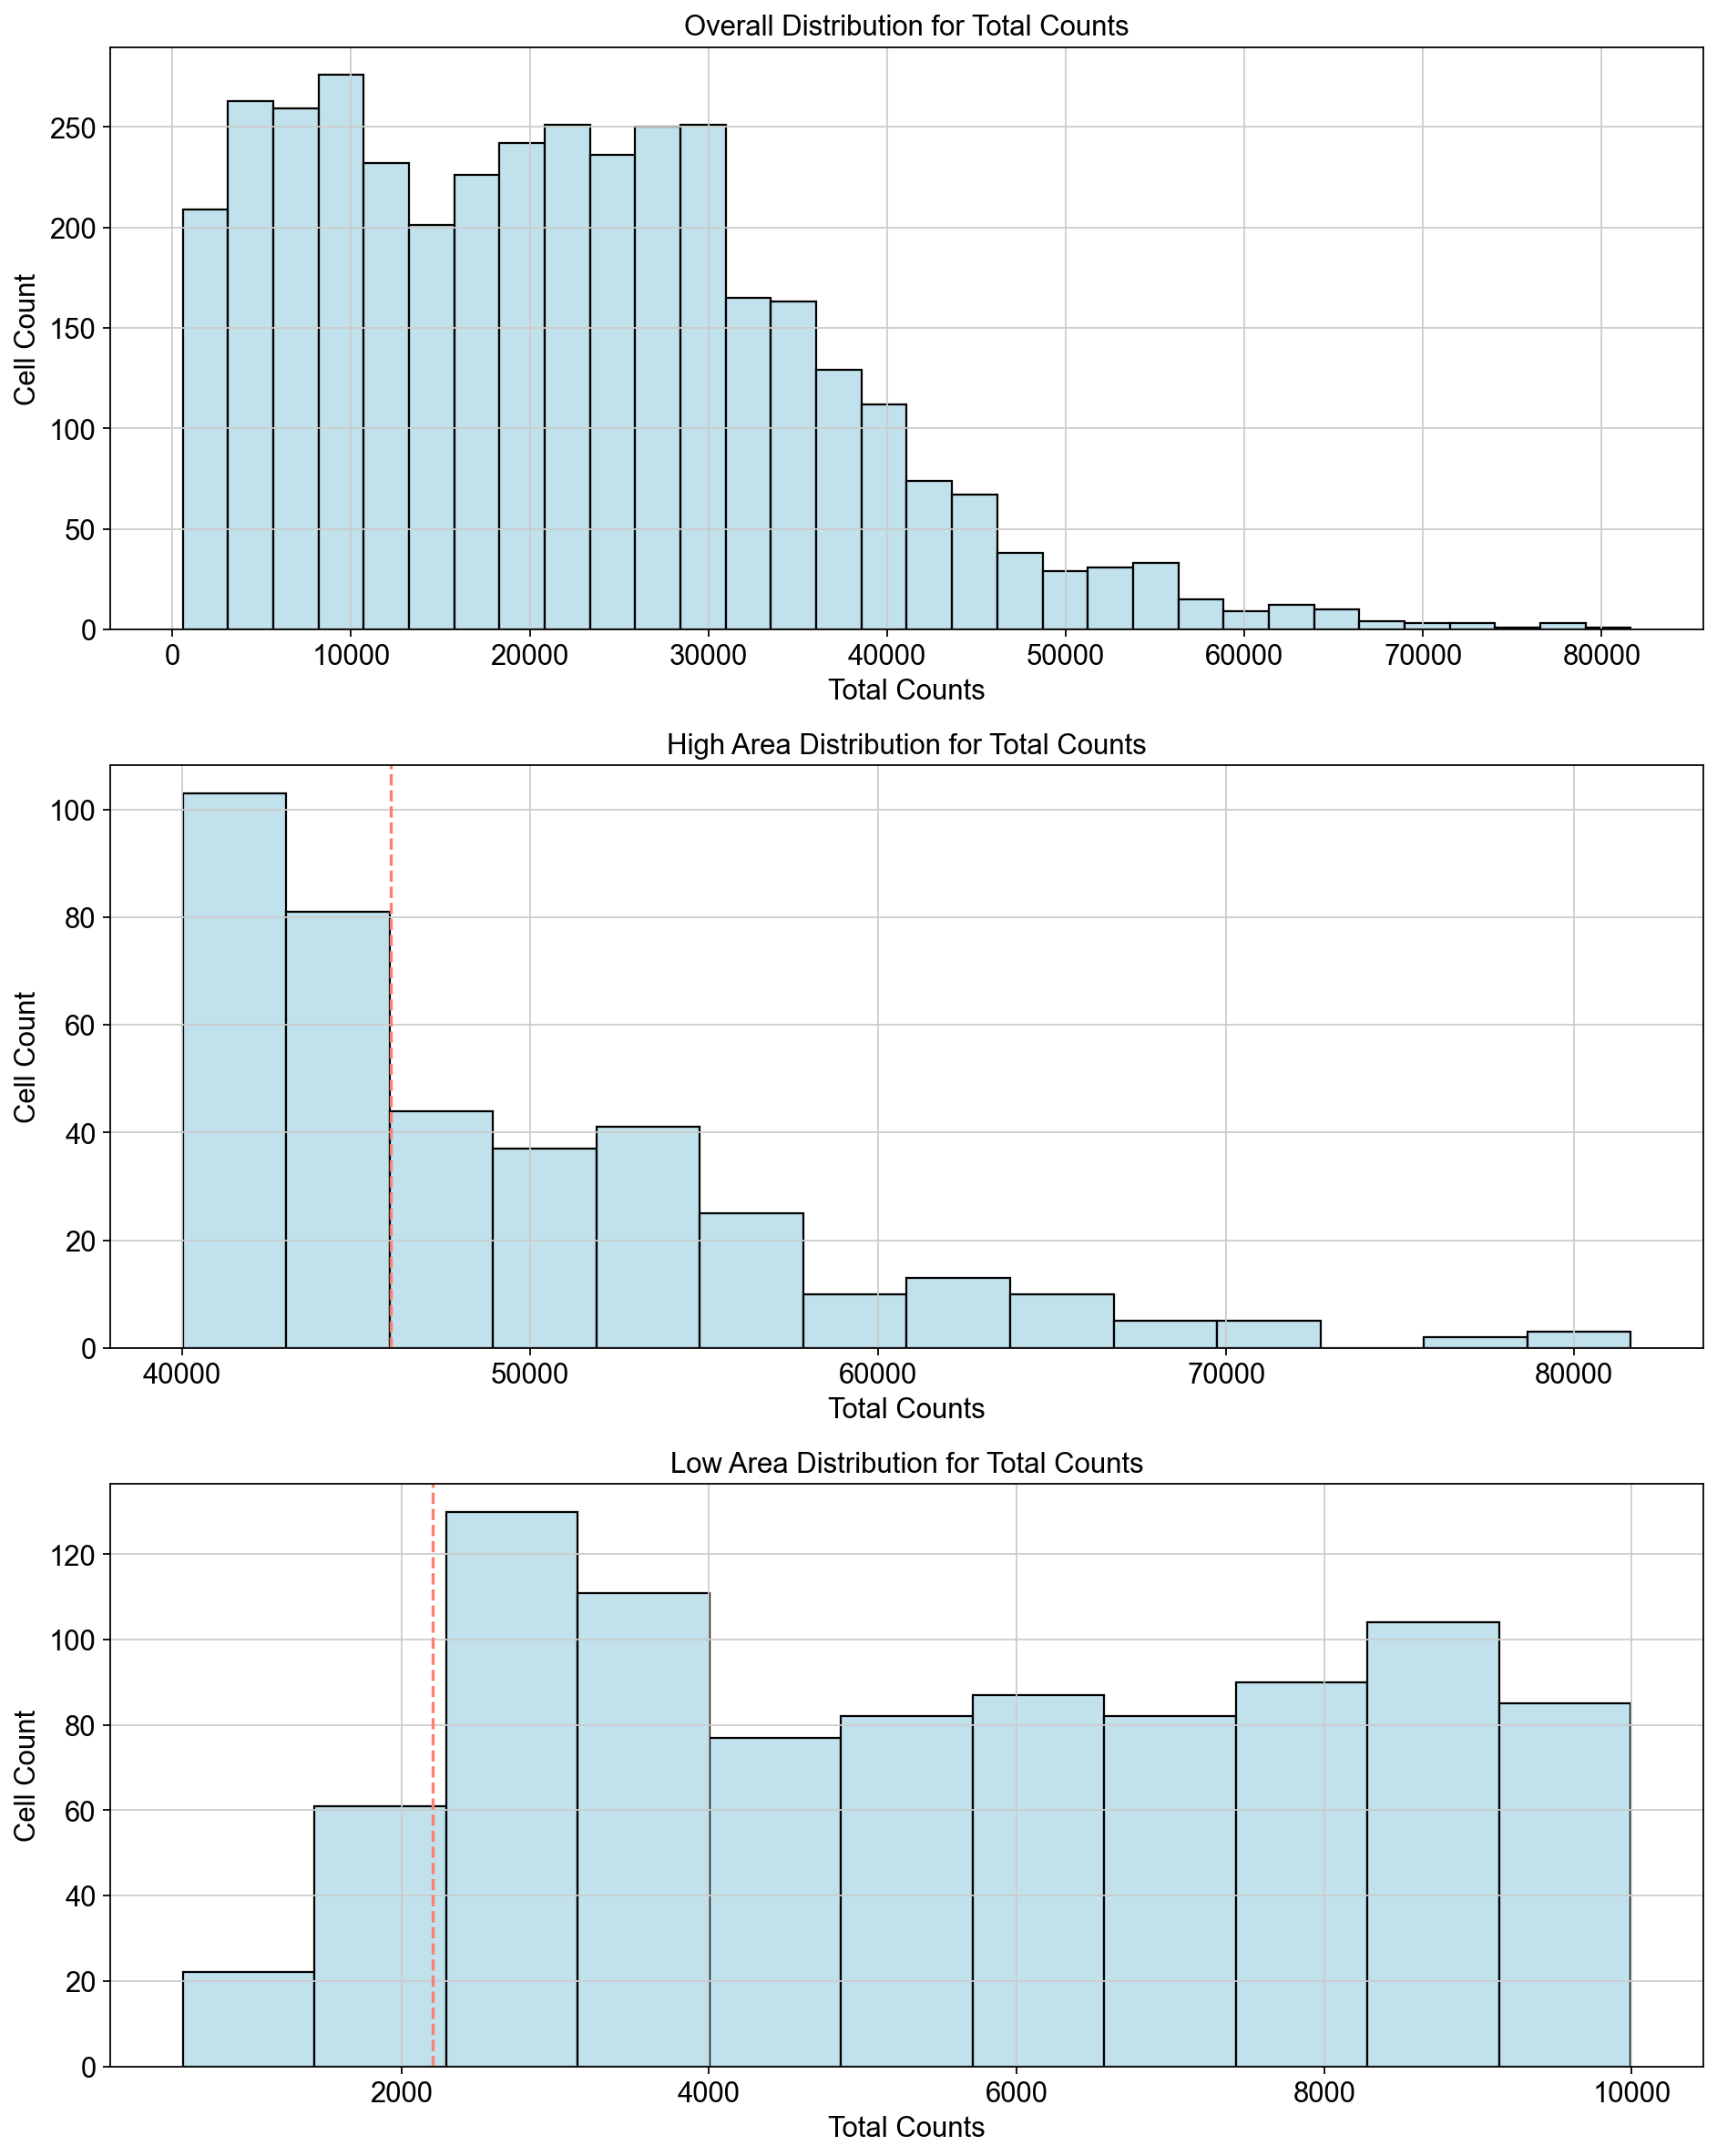

In [25]:
# Total Count distribution
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# Overall
sns.histplot(adata.obs["total_counts"], ax=axes[0], color="lightblue")
axes[0].set_title("Overall Distribution for Total Counts")
axes[0].set_xlabel("Total Counts")
axes[0].set_ylabel("Cell Count")

# High area
high_total_counts = adata.obs["total_counts"][adata.obs["total_counts"] > 40000]
sns.histplot(high_total_counts, ax=axes[1], color="lightblue")
axes[1].set_title("High Area Distribution for Total Counts")
axes[1].set_xlabel("Total Counts")
axes[1].set_ylabel("Cell Count")
axes[1].axvline(x=46000, color='salmon', linestyle='--')

# Low area
low_total_counts = adata.obs["total_counts"][adata.obs["total_counts"] < 10000]
sns.histplot(low_total_counts, ax=axes[2], color="lightblue")
axes[2].set_title("Low Area Distribution for Total Counts")
axes[2].set_xlabel("Total Counts")
axes[2].set_ylabel("Cell Count")
axes[2].axvline(x=2200, color='salmon', linestyle='--')

plt.tight_layout()
plt.show()


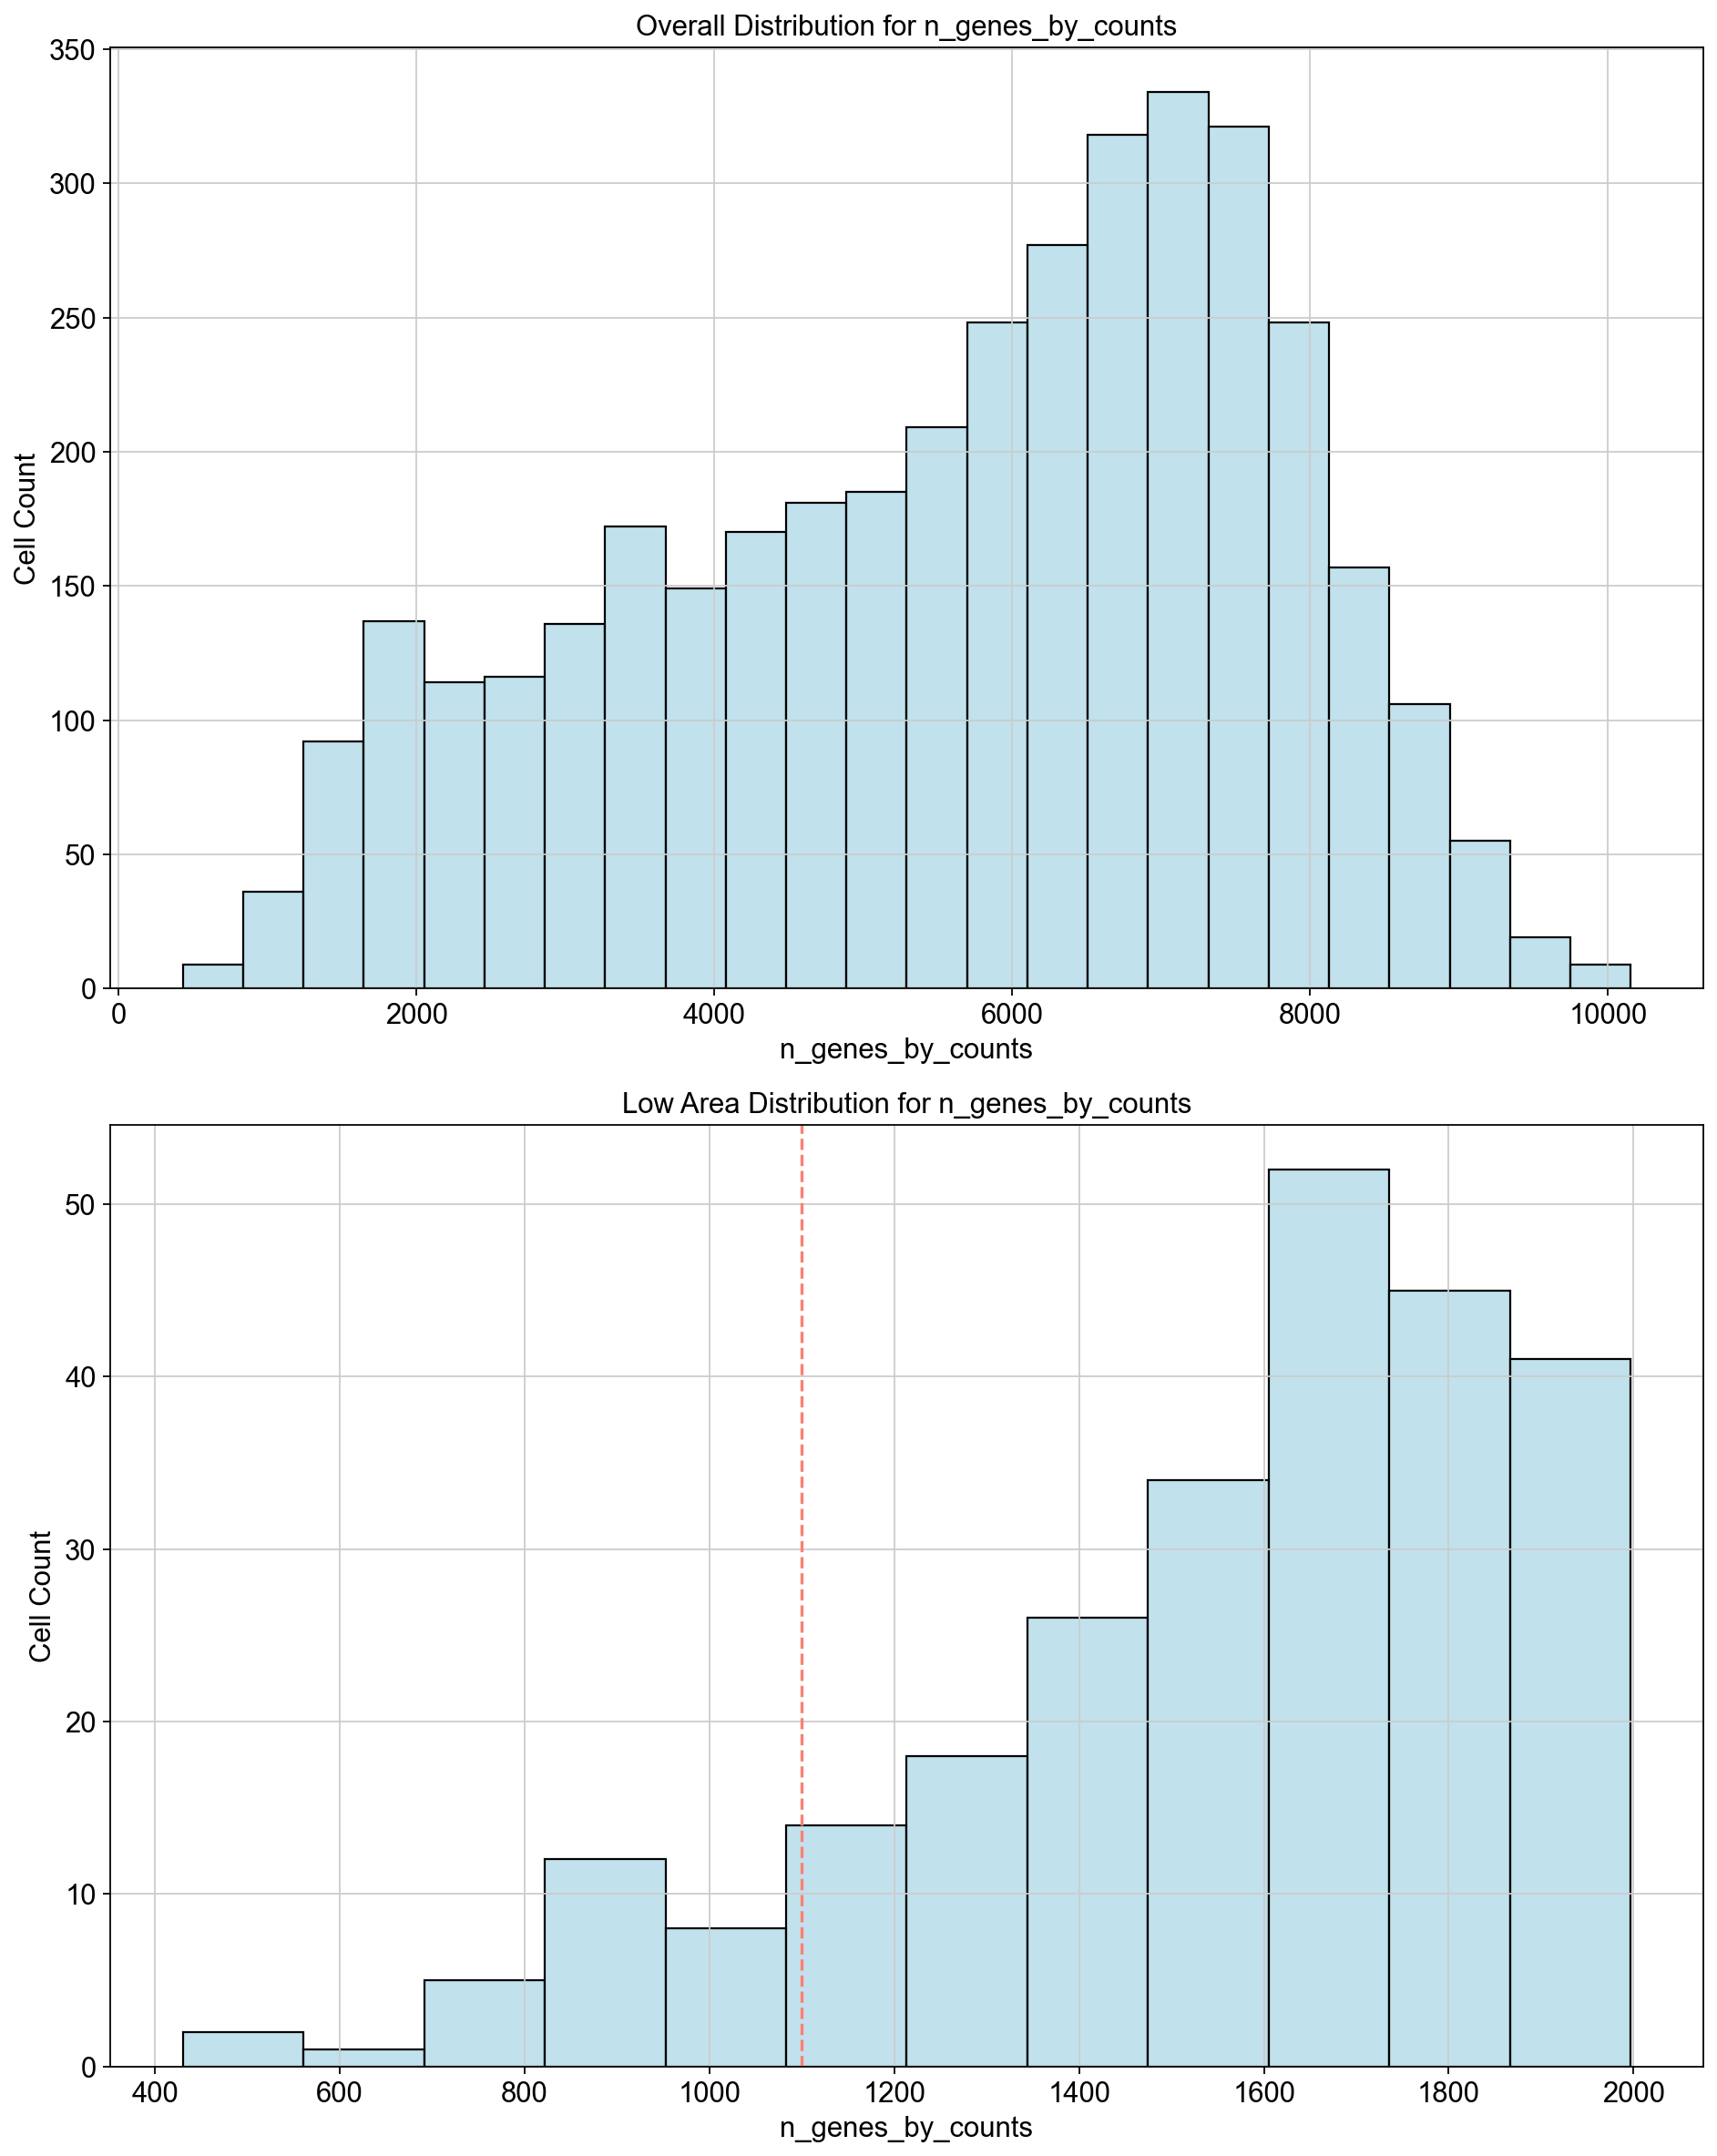

In [26]:
# Total Count distribution
fig, axes = plt.subplots(2, 1, figsize=(12, 15))

# Overall
sns.histplot(adata.obs["n_genes_by_counts"], ax=axes[0], color="lightblue")
axes[0].set_title("Overall Distribution for n_genes_by_counts")
axes[0].set_xlabel("n_genes_by_counts")
axes[0].set_ylabel("Cell Count")

# Low area
low_genes_counts = adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 2000]
sns.histplot(low_genes_counts, ax=axes[1], color="lightblue")
axes[1].set_title("Low Area Distribution for n_genes_by_counts")
axes[1].set_xlabel("n_genes_by_counts")
axes[1].set_ylabel("Cell Count")
axes[1].axvline(x=1100, color='salmon', linestyle='--')


plt.tight_layout()
plt.show()


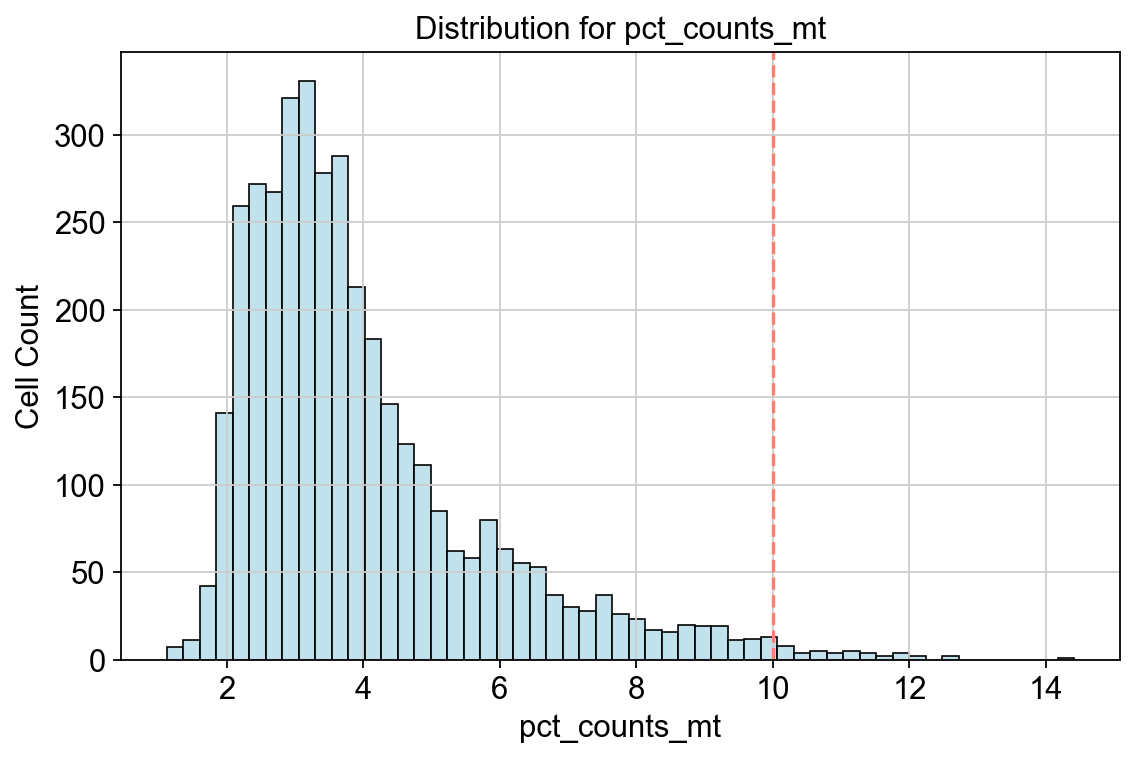

In [27]:
# percentage for mt
fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(adata.obs["pct_counts_mt"], color="lightblue", ax=ax)
ax.set_title("Distribution for pct_counts_mt")
ax.set_xlabel("pct_counts_mt")
ax.set_ylabel("Cell Count")
ax.axvline(x=10, color='salmon', linestyle='--')

plt.show()

In [28]:
# Filtering
adata_filtered = adata[
    (adata.obs["total_counts"] > 2200) & 
    (adata.obs["total_counts"] < 46000) & 
    (adata.obs["n_genes_by_counts"] > 1100) & 
    (adata.obs["pct_counts_mt"] < 10),
    :
]

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")


Number of cells after filtering of low quality cells: 3798


In 10x Genomics Visium spatial transcriptomics (ST) data, doublet detection is usually not necessary. 
- Each Spot Contains Multiple Cells.
- Doublets do not significantly affect analysis like in single-cell RNA-seq.
- In ST, each spot inherently contains mixed RNA, so doublets are usually not a major technical issue.
- ST is mainly used for spatial gene expression analysis, not single-cell classification.

### 3. Normalization

In [29]:
# adata_filtered = adata_filtered.copy()

sc.pp.normalize_total(adata_filtered, target_sum=1e4)
sc.pp.log1p(adata_filtered)
 # store normalized data for PCA, clustering, etc.

/Users/gloriasong/anaconda3/envs/single_cell_env/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


### 4. Feature Selection

Similar, in spatial transcriptomics (ST) data, feature selection aims to identify highly variable genes (HVGs) for dimensionality reduction (PCA/UMAP) and clustering analysis.



/Users/gloriasong/anaconda3/envs/single_cell_env/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


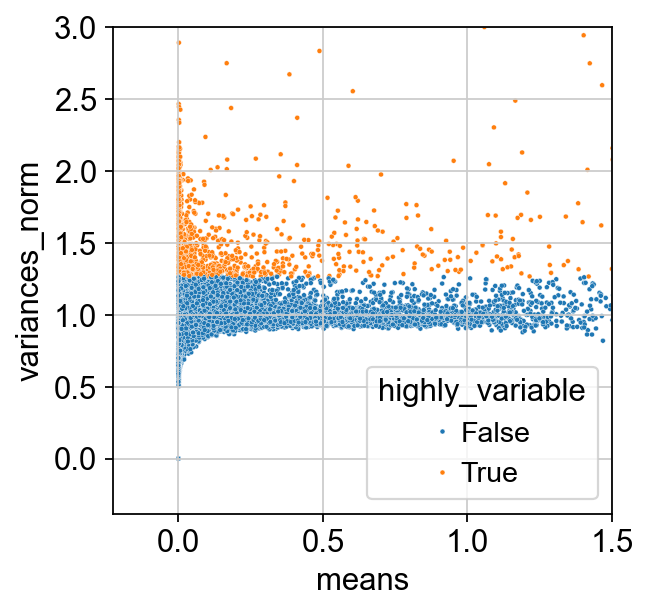

In [30]:
sc.pp.highly_variable_genes(adata_filtered, flavor="seurat_v3", n_top_genes=2000)

ax = sns.scatterplot(
    data=adata_filtered.var, x="means", y="variances_norm", hue="highly_variable", s=5
)
ax.set_xlim(None, 1.5)
ax.set_ylim(None, 3)
plt.show()

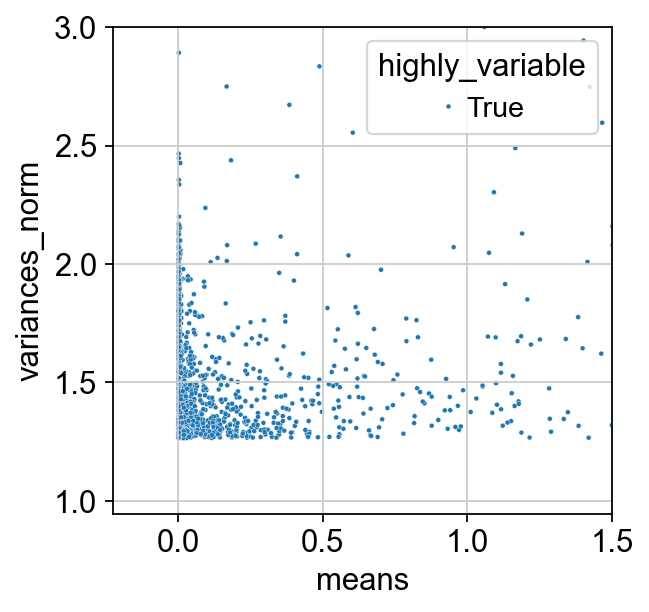

In [31]:
# filtering
adata_filtered = adata_filtered[:, adata_filtered.var["highly_variable"]]

ax = sns.scatterplot(
    data=adata_filtered.var, x="means", y="variances_norm", hue="highly_variable", s=5
)
ax.set_xlim(None, 1.5)
ax.set_ylim(None, 3)
plt.show()

### 5. Dimensionality Reduction

The reason for using `arpack`:
- Spatial data is large and often contains many zero values.
- Only compute the first n_components principal components instead of the full SVD, saving computational resources.
- Uses an exact iterative method, which can provide more stable results
- ST data usually have strong spatial patterns and technical batch effects, "arpack" can better extract the real biological variation instead of being affected by noise.

/Users/gloriasong/anaconda3/envs/single_cell_env/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


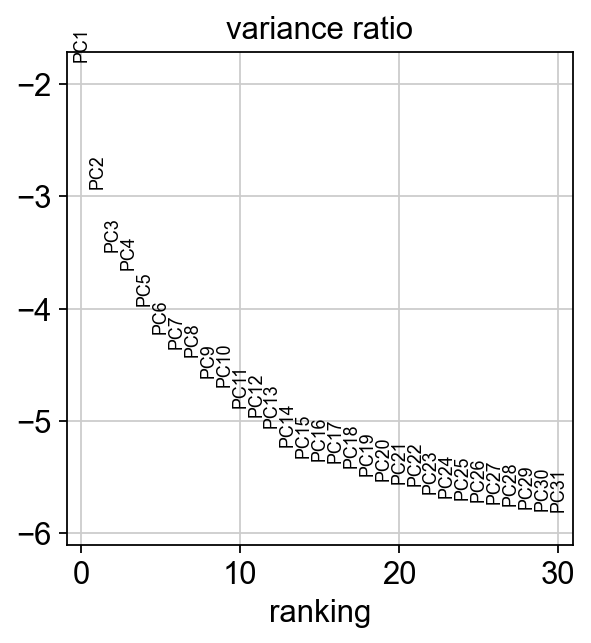

In [32]:
# adata = adata.copy()
sc.tl.pca(adata_filtered, svd_solver="arpack")
sc.pl.pca_variance_ratio(adata_filtered, log=True)

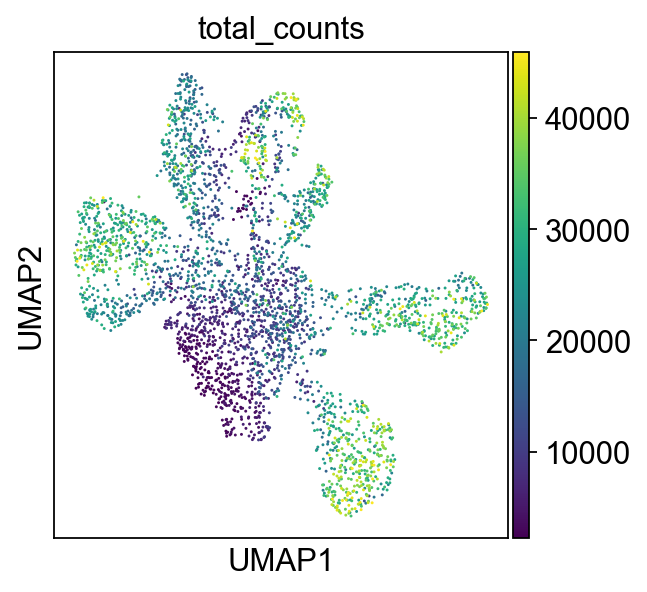

In [33]:
# neighborhood graph
sc.pp.neighbors(adata_filtered, n_pcs=13)
sc.tl.umap(adata_filtered)
sc.pl.umap(adata_filtered, color=["total_counts"], size = 7)

### 6. Clustering

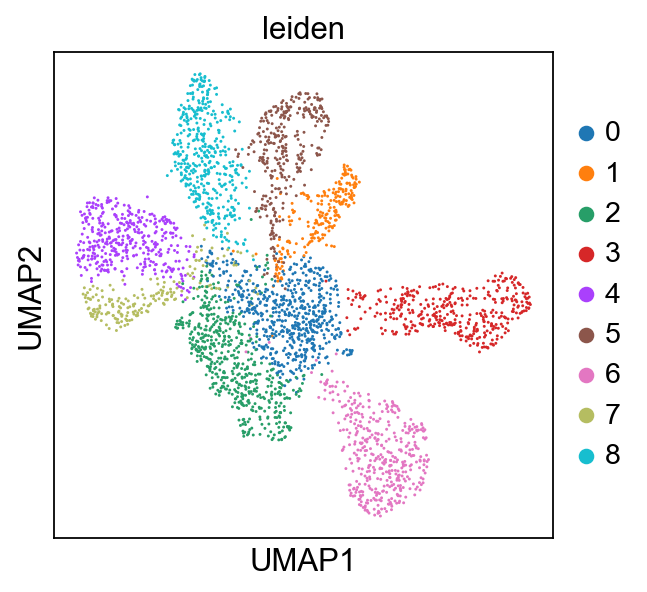

In [34]:
sc.tl.leiden(adata_filtered, flavor="igraph",
             n_iterations=2, resolution=0.5)
sc.pl.umap(adata_filtered, color=["leiden"], size=7)

*!! I got trouble with import squidpy.*

I should using squidpy packge:

```bash
sq.gr.spatial_neighbors(adata, coord_type="grid")
sq.gr.spatial_autocorr(adata, mode="moran")
```

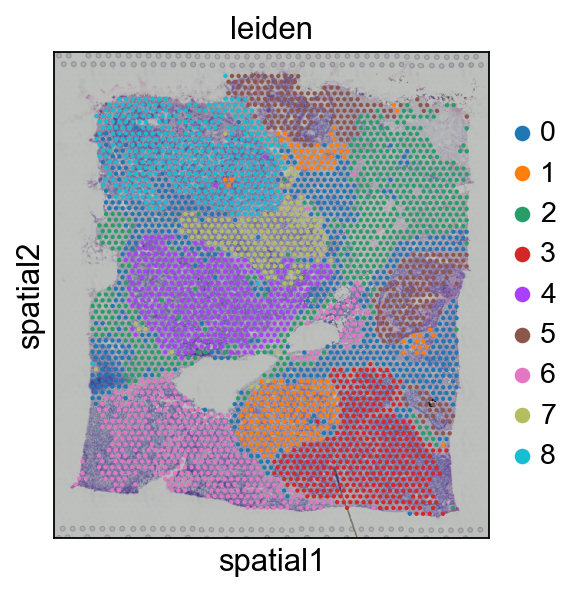

In [35]:
sc.pl.spatial(adata_filtered, color="leiden", img_key="hires")

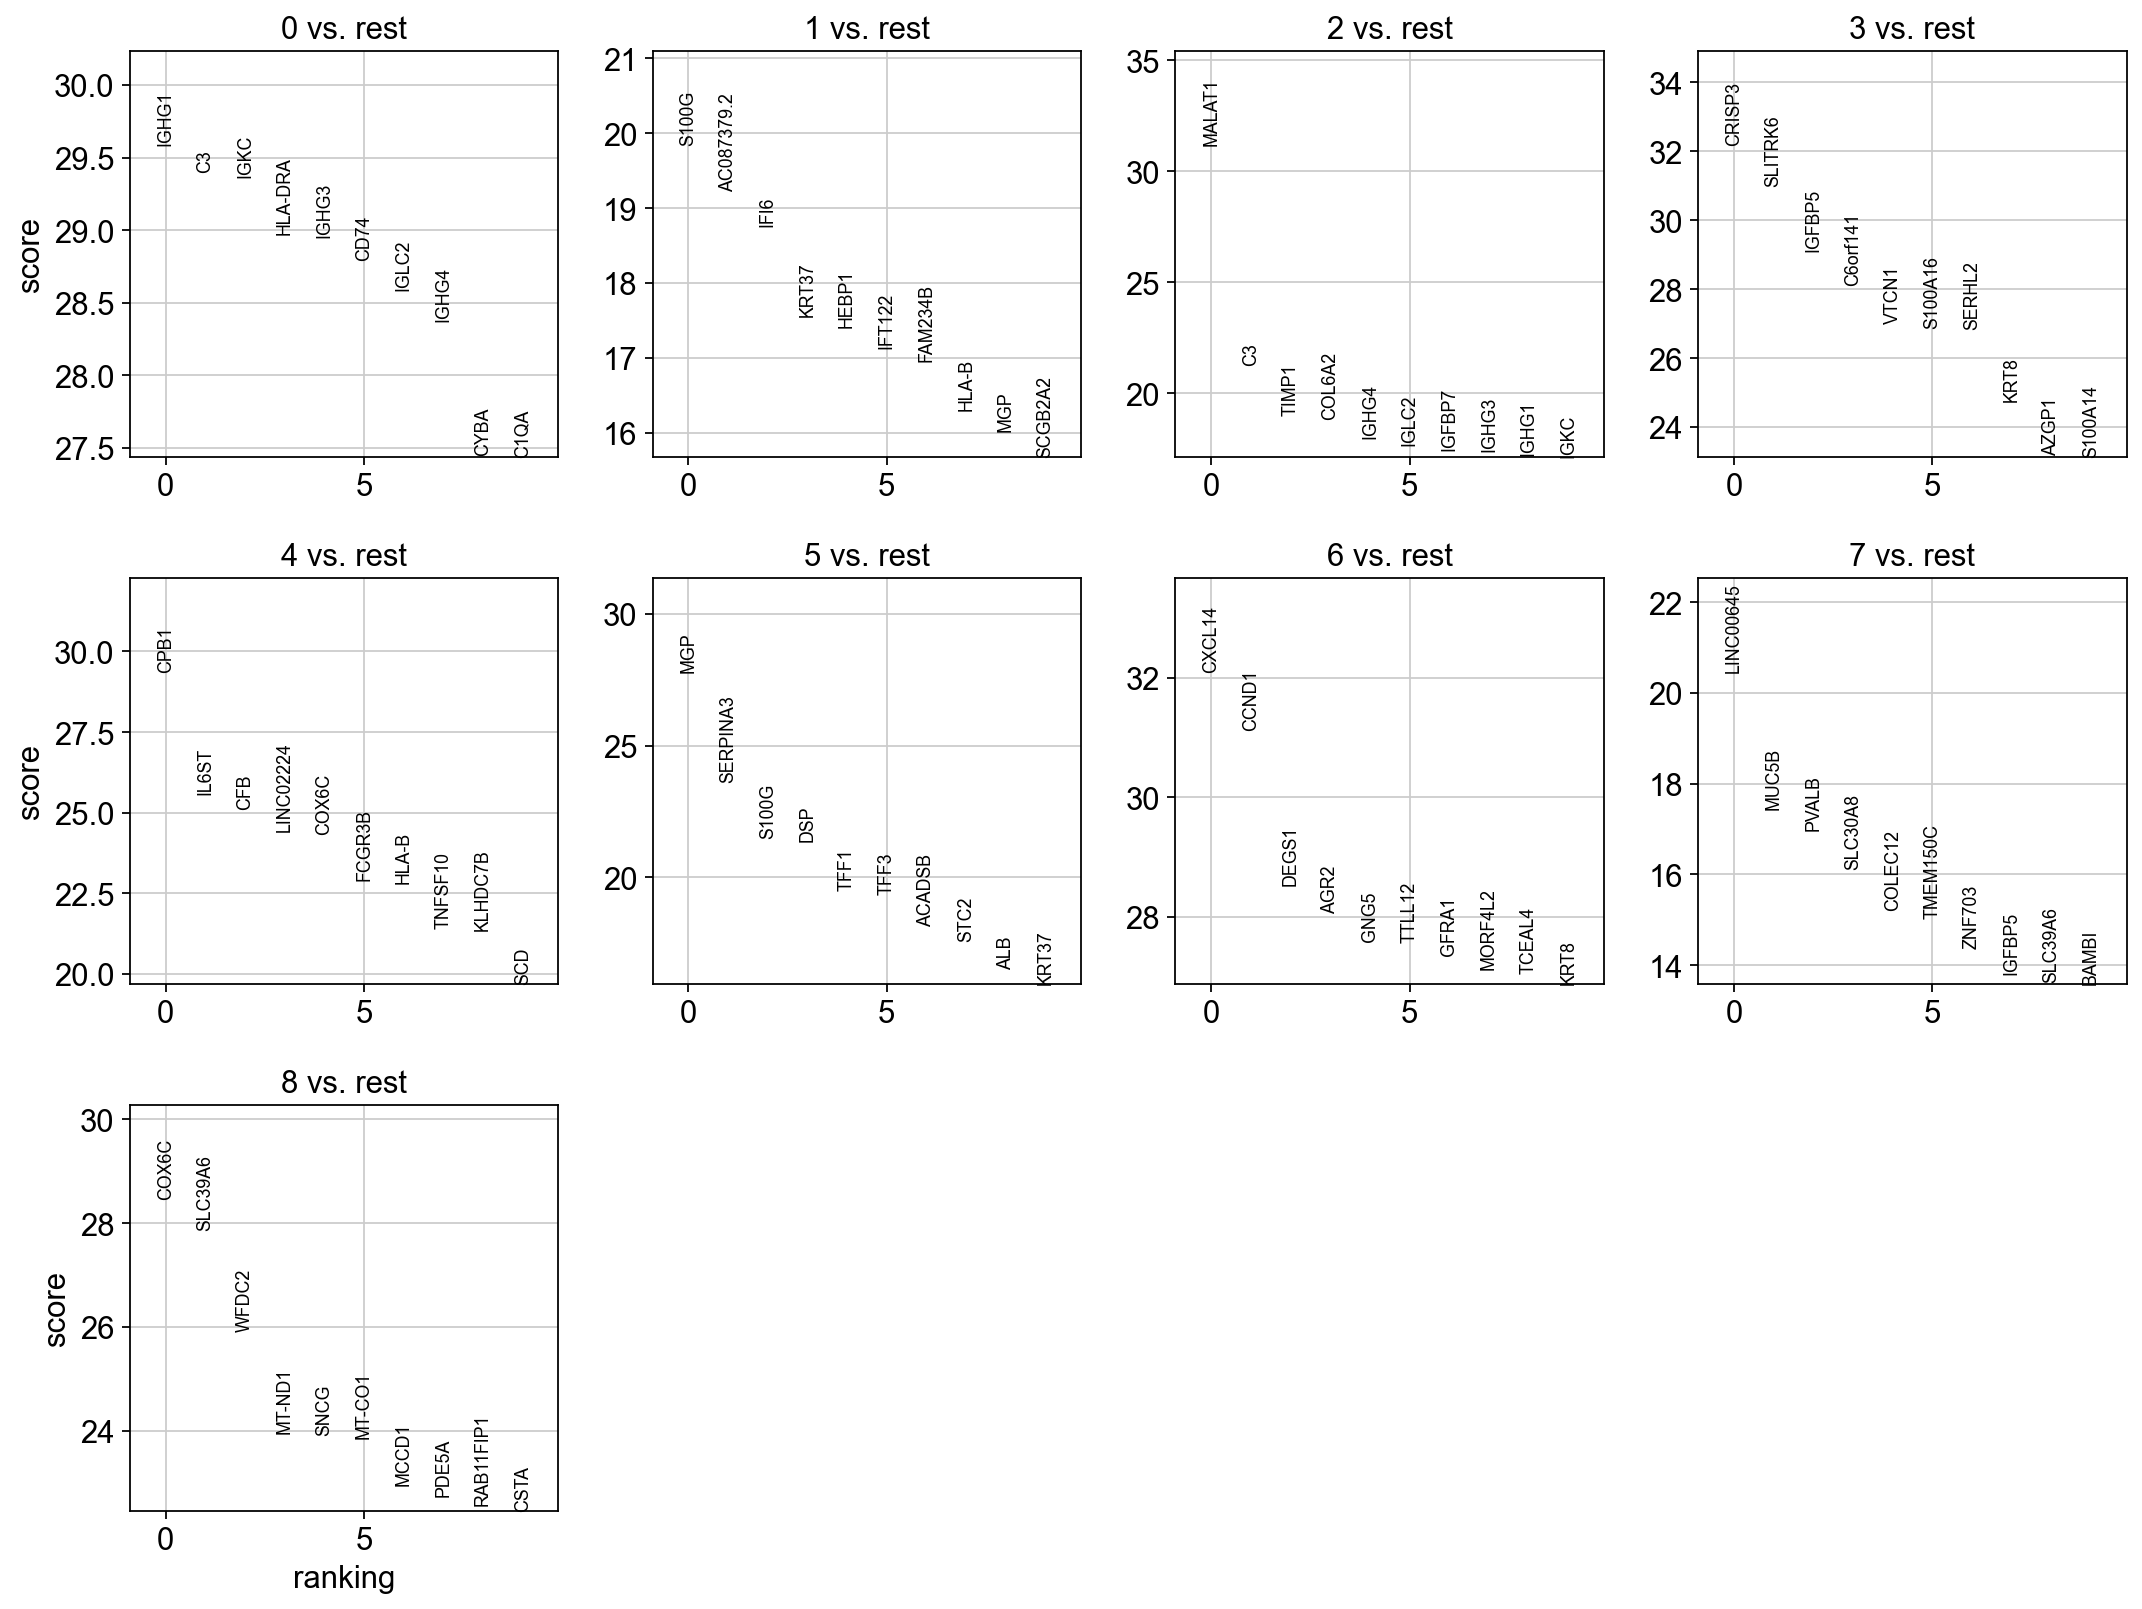

In [36]:
sc.tl.rank_genes_groups(adata_filtered, groupby="leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata_filtered, n_genes=10, sharey=False)
